In [2]:
# Install required libraries (run once).
import sys
# Uncomment the line below to install. In many managed environments this cell can be skipped if packages are already present.
# !{sys.executable} -m pip install -q tensorflow pandas scikit-learn matplotlib seaborn opencv-python
print('If you need to install packages, run:\npython -m pip install tensorflow pandas scikit-learn matplotlib seaborn opencv-python')


If you need to install packages, run:
python -m pip install tensorflow pandas scikit-learn matplotlib seaborn opencv-python


In [4]:
# Imports and basic config
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Paths (assumes notebook sits in same folder as the CSV and combined_images)
BASE_DIR = os.path.abspath('.')
CSV_PATH = os.path.join(BASE_DIR, 'Alzheimers_Clinical_Features.csv')
IMAGES_DIR = os.path.join(BASE_DIR, 'combined_images')
print('CSV:', CSV_PATH)
print('Images dir:', IMAGES_DIR)


CSV: c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aiml2037\New folder\archive\Alzheimers_Clinical_Features.csv
Images dir: c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aiml2037\New folder\archive\combined_images


In [6]:
# Load CSV and build a DataFrame with correct image paths
df = pd.read_csv(CSV_PATH)
# CSV uses names like 'NonDemented/image_001.jpg' but filesystem has '1.jpg' etc.
def csv_to_actual_path(row):
    # row['Image_Path'] -> e.g. 'NonDemented/image_001.jpg'
    class_name, fname = row['Image_Path'].split('/')
    m = re.search(r"(\d+)", fname)
    if not m:
        return None
    num = int(m.group(1))
    actual_fname = f'{num}.jpg'
    full = os.path.join(IMAGES_DIR, class_name, actual_fname)
    return full

df['image_file'] = df.apply(csv_to_actual_path, axis=1)
# drop rows where image missing
df = df[df['image_file'].notna()]
df = df[df['image_file'].apply(os.path.exists)]
df = df.reset_index(drop=True)
print('Total rows with existing images:', len(df))
df.head()


Total rows with existing images: 195


,Image_Path,Class,MMSE_Score,Clock_Drawing_Score,B12_Level_pg_mL,Thyroid_TSH_mIU_L,Glucose_mg_dL,p_tau181_ng_L,p_tau217_ng_L,Amyloid_Beta_Ratio,image_file
0,NonDemented/image_001.jpg,NonDemented,29,8,491.72,3.21,87.31,9.46,6.00,0.1567,c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aim...
1,NonDemented/image_002.jpg,NonDemented,30,10,410.29,3.89,94.14,7.12,6.82,0.1347,c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aim...
2,NonDemented/image_003.jpg,NonDemented,29,9,662.38,1.96,78.45,11.12,6.39,0.1434,c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aim...
3,NonDemented/image_004.jpg,NonDemented,28,10,891.62,2.08,94.94,11.80,9.50,0.1211,c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aim...
4,NonDemented/image_005.jpg,NonDemented,26,9,804.20,1.50,72.83,11.84,9.40,0.1298,c:\Users\User\OneDrive - WOXSEN UNIVERSITY\aim...


In [7]:
# Prepare labels and clinical features
target_col = 'Class'
le = LabelEncoder()
df['label'] = le.fit_transform(df[target_col])
class_names = list(le.classes_)
print('Classes:', class_names)
# Choose a small set of clinical columns (numeric) to keep things simple and reproducible
clinical_cols = ['MMSE_Score','Clock_Drawing_Score','B12_Level_pg_mL','Thyroid_TSH_mIU_L','Glucose_mg_dL']
for c in clinical_cols:
    if c not in df.columns:
        raise ValueError(f'Missing column: {c}')
X_clinical = df[clinical_cols].astype(float).values
y = df['label'].values
image_paths = df['image_file'].values
print('Shapes:', X_clinical.shape, image_paths.shape, y.shape)


Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Shapes: (195, 5) (195,) (195,)


In [8]:
# Train/test split (stratified)
train_idx, test_idx = train_test_split(np.arange(len(df)), test_size=0.2, stratify=y, random_state=RANDOM_SEED)
df_train = df.loc[train_idx].reset_index(drop=True)
df_test = df.loc[test_idx].reset_index(drop=True)
Xc_train = X_clinical[train_idx]
Xc_test = X_clinical[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]
print('Train / Test sizes:', len(df_train), len(df_test))


Train / Test sizes: 156 39


In [26]:
# Helper: build tf.data datasets for images and (optionally) clinical features
IMG_SIZE = (128,128)
BATCH = 8
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image

def make_image_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=RANDOM_SEED)
    ds = ds.map(lambda p, y: (load_and_preprocess(p), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_image_ds = make_image_dataset(df_train['image_file'].values, df_train['label'].values, shuffle=True)
test_image_ds = make_image_dataset(df_test['image_file'].values, df_test['label'].values, shuffle=False)

# Clinical scaler (fit on train only)
scaler = StandardScaler()
scaler.fit(Xc_train)
Xc_train_s = scaler.transform(Xc_train)
Xc_test_s = scaler.transform(Xc_test)

# Small helper to build combined tf.data (image, clinical) -> label
def make_combined_dataset(image_paths, clinical_array, labels, shuffle=True):
    ds_images = tf.data.Dataset.from_tensor_slices(image_paths)
    ds_clin = tf.data.Dataset.from_tensor_slices(clinical_array.astype(np.float32))
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((ds_images, ds_clin, ds_labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(labels), seed=RANDOM_SEED)
    ds = ds.map(lambda p, c, y: ((load_and_preprocess(p), c), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_combined_ds = make_combined_dataset(df_train['image_file'].values, Xc_train_s, y_train, shuffle=True)
test_combined_ds = make_combined_dataset(df_test['image_file'].values, Xc_test_s, y_test, shuffle=False)

print('Datasets ready')


Datasets ready


In [27]:
# Build a small CNN model (image-only)
def build_cnn(num_classes):
    inputs = Input(shape=(*IMG_SIZE,3))
    x = layers.Conv2D(16,3,activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32,3,activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

num_classes = len(class_names)
cnn_model = build_cnn(num_classes)
cnn_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235,172 (12.34 MB)

 Trainable params: 3,235,172 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train image-only CNN (short run to be matchable)
EPOCHS = 8
history_img = cnn_model.fit(train_image_ds, epochs=EPOCHS, validation_data=test_image_ds)


Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.2756 - loss: 1.5989 - val_accuracy: 0.2821 - val_loss: 1.3716
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.2756 - loss: 1.5989 - val_accuracy: 0.2821 - val_loss: 1.3716
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3590 - loss: 1.3508 - val_accuracy: 0.2564 - val_loss: 1.4204
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3590 - loss: 1.3508 - val_accuracy: 0.2564 - val_loss: 1.4204
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3974 - loss: 1.2341 - val_accuracy: 0.3333 - val_loss: 1.2992
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3974 - loss: 1.2341 - val_accuracy: 0.3333 - val_loss: 1.2992
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5321 - loss: 1.0911 - val_accuracy: 0.4103 - val_loss: 1.3494
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5321 - loss: 1.0911 - val_accuracy: 0.4103 - val_loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


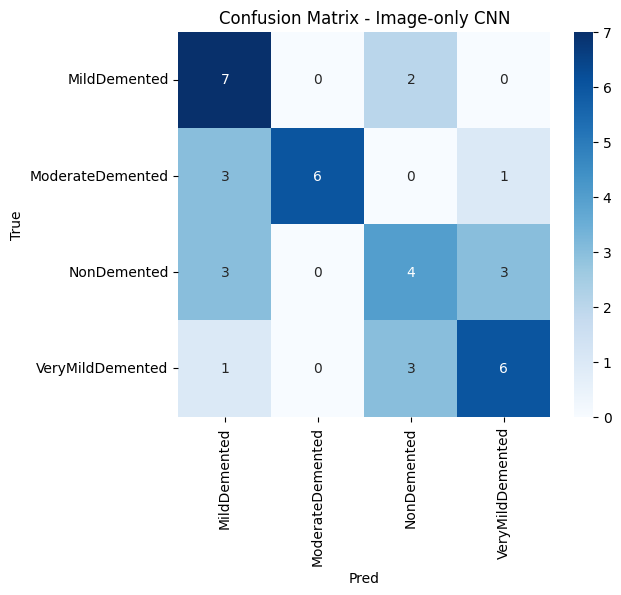

                  precision    recall  f1-score   support

    MildDemented       0.50      0.78      0.61         9
ModerateDemented       1.00      0.60      0.75        10
     NonDemented       0.44      0.40      0.42        10
VeryMildDemented       0.60      0.60      0.60        10

        accuracy                           0.59        39
       macro avg       0.64      0.59      0.59        39
    weighted avg       0.64      0.59      0.59        39



In [ ]:
# Evaluate and confusion matrix for image-only model
y_pred_prob = cnn_model.predict(test_image_ds)
y_pred = np.argmax(y_pred_prob, axis=1)
# Because test_image_ds is batched, build true labels in order:
y_true = np.concatenate([y for x, y in test_image_ds], axis=0)
cm_img = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm_img, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix - Image-only CNN')
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()
print(classification_report(y_true, y_pred, target_names=class_names))


In [30]:
# Compute FP and FN per class helper
def fp_fn_from_cm(cm):
    # cm: rows true, cols pred
    fps = {}
    fns = {}
    for i, cname in enumerate(class_names):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        fps[cname] = int(fp)
        fns[cname] = int(fn)
    return fps, fns

fps_img, fns_img = fp_fn_from_cm(cm_img)
print('Image-only model FP per class:', fps_img)
print('Image-only model FN per class:', fns_img)


Image-only model FP per class: {'MildDemented': 7, 'ModerateDemented': 0, 'NonDemented': 5, 'VeryMildDemented': 4}
Image-only model FN per class: {'MildDemented': 2, 'ModerateDemented': 4, 'NonDemented': 6, 'VeryMildDemented': 4}


In [31]:
# Build a combined model: CNN image branch + clinical dense branch
def build_cnn_plus_clinical(num_clinical, num_classes):
    img_input = Input(shape=(*IMG_SIZE,3), name='img_input')
    x = layers.Conv2D(16,3,activation='relu')(img_input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32,3,activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)

    clin_input = Input(shape=(num_clinical,), name='clin_input')
    c = layers.Dense(32, activation='relu')(clin_input)

    concat = layers.concatenate([x, c])
    z = layers.Dense(64, activation='relu')(concat)
    out = layers.Dense(num_classes, activation='softmax')(z)
    model = Model([img_input, clin_input], out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

num_clin = Xc_train_s.shape[1]
combined_model = build_cnn_plus_clinical(num_clin, num_classes)
combined_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 126,  │        448 │ img_input[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 63, 63,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 61,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 30, 30,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 28800)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clin_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │  1,843,264 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │        192 │ clin_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 4)         │        260 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,855,012 (7.08 MB)

 Trainable params: 1,855,012 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train combined model
EPOCHS_C = 8
history_comb = combined_model.fit(train_combined_ds, epochs=EPOCHS_C, validation_data=test_combined_ds)


Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5385 - loss: 1.1378 - val_accuracy: 0.5385 - val_loss: 1.0007
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5385 - loss: 1.1378 - val_accuracy: 0.5385 - val_loss: 1.0007
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6731 - loss: 0.8713 - val_accuracy: 0.6410 - val_loss: 0.8210
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6731 - loss: 0.8713 - val_accuracy: 0.6410 - val_loss: 0.8210
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7500 - loss: 0.6960 - val_accuracy: 0.5385 - val_loss: 0.7770
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7500 - loss: 0.6960 - val_accuracy: 0.5385 - val_loss: 0.7770
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8397 - loss: 0.5754 - val_accuracy: 0.6923 - val_loss: 0.6052
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8397 - loss: 0.5754 - val_accuracy: 0.6923 - val_loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


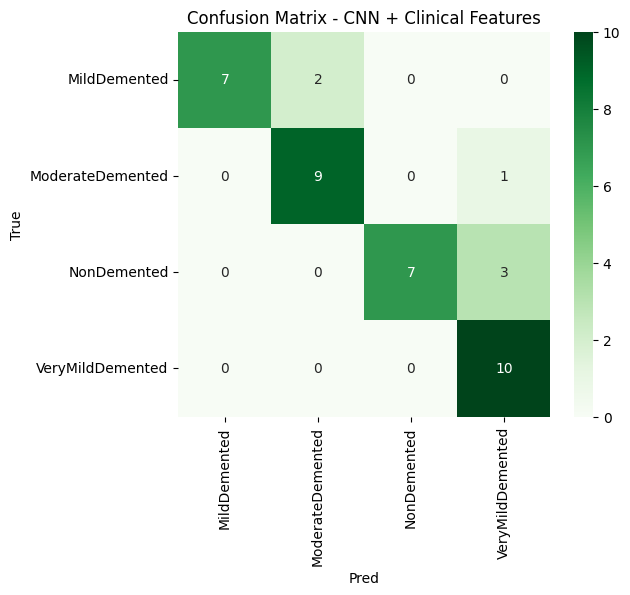

                  precision    recall  f1-score   support

    MildDemented       1.00      0.78      0.88         9
ModerateDemented       0.82      0.90      0.86        10
     NonDemented       1.00      0.70      0.82        10
VeryMildDemented       0.71      1.00      0.83        10

        accuracy                           0.85        39
       macro avg       0.88      0.84      0.85        39
    weighted avg       0.88      0.85      0.85        39



In [33]:
# Evaluate and confusion matrix for combined model
# Build arrays of test inputs to run predict (so ordering matches)
img_test_paths = df_test['image_file'].values
clin_test = Xc_test_s.astype(np.float32)
# Build image tensor array (small dataset: safe to load into memory). Uses the same preprocessing function as the dataset.
img_list = [load_and_preprocess(p) for p in img_test_paths]
# Stack into one numpy array
img_test_array = tf.stack(img_list).numpy()
# Predict using list of inputs so model gets both tensors
pred_prob = combined_model.predict([img_test_array, clin_test], batch_size=BATCH)
y_pred_c = np.argmax(pred_prob, axis=1)
y_true_c = y_test
cm_comb = confusion_matrix(y_true_c, y_pred_c)
plt.figure(figsize=(6,5))
sns.heatmap(cm_comb, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.title('Confusion Matrix - CNN + Clinical Features')
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()
print(classification_report(y_true_c, y_pred_c, target_names=class_names))


In [35]:
# FP / FN for combined model and comparison table
fps_comb, fns_comb = fp_fn_from_cm(cm_comb)
print('Combined model FP per class:', fps_comb)
print('Combined model FN per class:', fns_comb)

# Make a small comparison summary per class
print('\nPer-class comparison (FP, FN):')
for cname in class_names:
    print(f"{cname}: image-only FP={fps_img[cname]}, FN={fns_img[cname]} | combined FP={fps_comb[cname]}, FN={fns_comb[cname]}")


Combined model FP per class: {'MildDemented': 0, 'ModerateDemented': 2, 'NonDemented': 0, 'VeryMildDemented': 4}
Combined model FN per class: {'MildDemented': 2, 'ModerateDemented': 1, 'NonDemented': 3, 'VeryMildDemented': 0}

Per-class comparison (FP, FN):
MildDemented: image-only FP=7, FN=2 | combined FP=0, FN=2
ModerateDemented: image-only FP=0, FN=4 | combined FP=2, FN=1
NonDemented: image-only FP=5, FN=6 | combined FP=0, FN=3
VeryMildDemented: image-only FP=4, FN=4 | combined FP=4, FN=0


Overall accuracy - Image-only: 0.5897, Combined: 0.8462


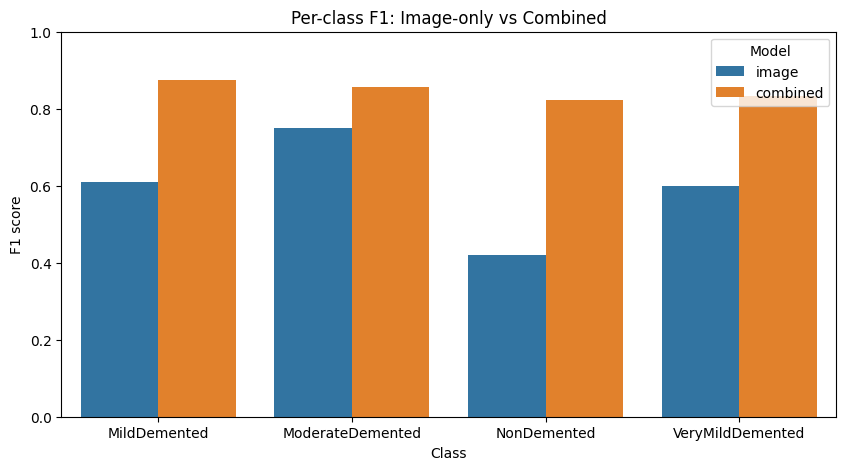

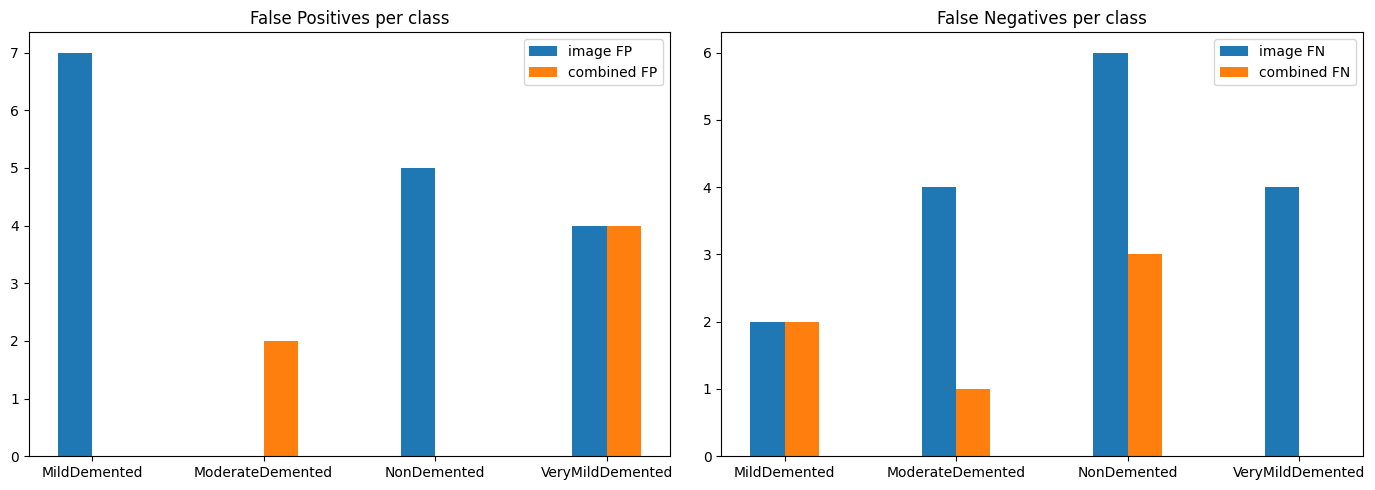

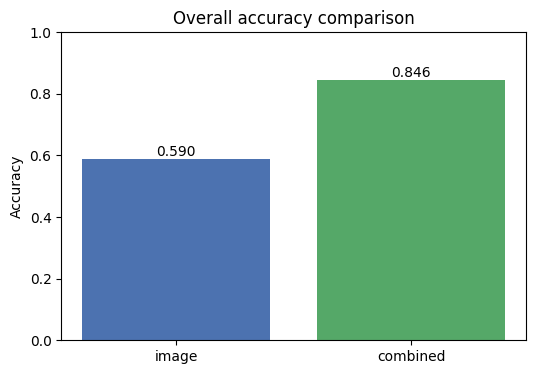


Per-class F1 summary:
model             class  combined     image
0          MildDemented  0.875000  0.608696
1      ModerateDemented  0.857143  0.750000
2           NonDemented  0.823529  0.421053
3      VeryMildDemented  0.833333  0.600000


In [36]:
# Comparison plots: per-class F1, FP/FN, and overall accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Overall accuracy
acc_img = accuracy_score(y_true, y_pred)
acc_comb = accuracy_score(y_true_c, y_pred_c)
print(f"Overall accuracy - Image-only: {acc_img:.4f}, Combined: {acc_comb:.4f}")

# Per-class precision/recall/f1
prec_i, rec_i, f1_i, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(num_classes), zero_division=0)
prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(y_true_c, y_pred_c, labels=range(num_classes), zero_division=0)

# DataFrame for plotting
df_metrics = pd.DataFrame({
    'class': list(class_names) * 2,
    'model': ['image'] * num_classes + ['combined'] * num_classes,
    'precision': list(prec_i) + list(prec_c),
    'recall': list(rec_i) + list(rec_c),
    'f1': list(f1_i) + list(f1_c)
})

plt.figure(figsize=(10,5))
sns.barplot(data=df_metrics, x='class', y='f1', hue='model')
plt.title('Per-class F1: Image-only vs Combined')
plt.ylim(0,1)
plt.ylabel('F1 score')
plt.xlabel('Class')
plt.legend(title='Model')
plt.show()

# FP / FN comparison per class
fp_vals_img = [fps_img[c] for c in class_names]
fn_vals_img = [fns_img[c] for c in class_names]
fp_vals_comb = [fps_comb[c] for c in class_names]
fn_vals_comb = [fns_comb[c] for c in class_names]

x = np.arange(len(class_names))
width = 0.2

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=False)
# FP subplot
axes[0].bar(x - width/2, fp_vals_img, width, label='image FP')
axes[0].bar(x + width/2, fp_vals_comb, width, label='combined FP')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names)
axes[0].set_title('False Positives per class')
axes[0].legend()
# FN subplot
axes[1].bar(x - width/2, fn_vals_img, width, label='image FN')
axes[1].bar(x + width/2, fn_vals_comb, width, label='combined FN')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].set_title('False Negatives per class')
axes[1].legend()
plt.tight_layout()
plt.show()

# Overall accuracy bar chart
plt.figure(figsize=(6,4))
plt.bar(['image','combined'], [acc_img, acc_comb], color=['#4C72B0','#55A868'])
plt.ylim(0,1)
plt.title('Overall accuracy comparison')
plt.ylabel('Accuracy')
for i, v in enumerate([acc_img, acc_comb]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

# Optional: store comparison DataFrame for later use
comparison_summary = df_metrics.pivot(index='class', columns='model', values='f1').reset_index()
print('\nPer-class F1 summary:')
print(comparison_summary)
